# Importers

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from torch import nn


import warnings

warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score


from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay,classification_report,balanced_accuracy_score

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from mlxtend.classifier import StackingClassifier
import os
from river import ensemble
from models.oned_cnn import CNN
from utils.dataset import TrainDataset, ValDataset, TestDataset
from models.CNN_attention_GRU import CANintelliIDS
from models.conv_lstm import ConvLSTM
from sklearn.ensemble import StackingClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


In [4]:
train_dataloader = DataLoader(dataset=TrainDataset(), batch_size = 1024, shuffle=True,num_workers=0)

In [5]:
val_dataloader = DataLoader(dataset=ValDataset(), batch_size = 1024, shuffle=True,num_workers=0)

In [6]:
test_dataloader = DataLoader(dataset=TestDataset(), batch_size = 1024, shuffle=False,num_workers=0)

In [7]:
dataset_directory = r'utils\dataset_files'

In [8]:
xy = pd.read_csv(os.path.join(dataset_directory,"Test_DS.csv"))
xy.columns= ['Timestamp', 'CAN_ID', 'RTR', 'DLC', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7','Label','Anomaly_Label',\
      'Mean', 'Median','Skew', 'Kurtosis', 'Variance', 'Standard_deviation']
x_test = torch.from_numpy(xy.loc[:, ~xy.columns.isin(['Mean', 'Median','Skew', 'Kurtosis', 'Variance', 'Standard_deviation','Label', 'Anomaly_Label',])].to_numpy())
x_test = x_test.float()
y_test= torch.from_numpy(xy.loc[:, 'Anomaly_Label'].to_numpy())
y_test = y_test.long()

# ConvLSTM

In [27]:
model1=ConvLSTM.load_from_checkpoint('conv_lstm.ckpt')

In [28]:
model1.eval()

ConvLSTM(
  (conv1): Conv1d(1, 18, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(18, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (lstm1): LSTM(12, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (metric): CrossEntropyLoss()
)

In [29]:
model1.to('cuda')
model1.eval()
y_pred_list = []
for batch in test_dataloader:
    with torch.no_grad():
    

        x,_ = batch
        y_pred = model1(x.to('cuda'))
        y_pred_list.append(y_pred)

y_pred = torch.cat(y_pred_list)

y_pred_cnnlstm = torch.argmax(y_pred,axis=1)

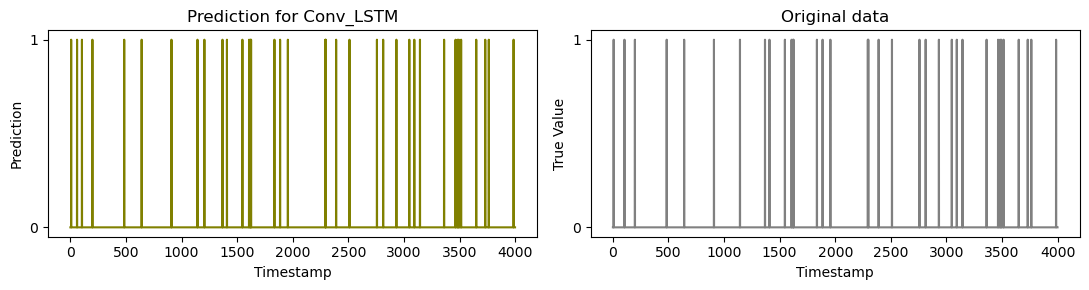

<Figure size 1200x300 with 0 Axes>

In [52]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (12,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for Conv_LSTM")
plt.plot(np.arange(len(y_pred_cnnlstm[19000:23000].cpu())),y_pred_cnnlstm[19000:23000].cpu(),color="olive")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Conv_LSTM.png')

86.0


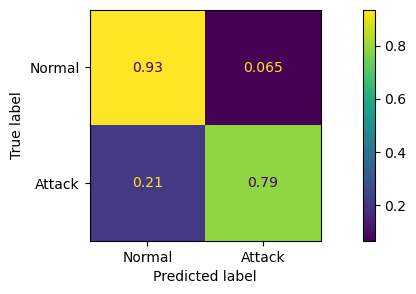

In [45]:
model_cm =confusion_matrix(y_test, y_pred_cnnlstm.cpu().detach().numpy(),normalize='true')
# print(round(accuracy_score(y_test, y_pred_cnnlstm.cpu()),2)*100)
y_acc = accuracy_score(y_test, y_pred_cnnlstm.cpu())
y_f1score = f1_score(y_test, y_pred_cnnlstm.cpu())
y_recall = recall_score(y_test, y_pred_cnnlstm.cpu())
print(round(balanced_accuracy_score(y_test, y_pred_cnnlstm.cpu()),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()

In [32]:
print(classification_report(y_test, y_pred_cnnlstm.cpu()))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94   1560065
           1       0.74      0.79      0.76    363663

    accuracy                           0.91   1923728
   macro avg       0.84      0.86      0.85   1923728
weighted avg       0.91      0.91      0.91   1923728



# CNN

In [9]:
model2 = CNN.load_from_checkpoint("oned_cnn.ckpt")

In [10]:
model2.eval()

CNN(
  (conv1d_layer_1): Sequential(
    (0): Conv1d(1, 12, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv1d_layer_2): Sequential(
    (0): Conv1d(12, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (linear3): Linear(in_features=144, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (metric): CrossEntropyLoss()
)

In [35]:
model2.to('cuda')
model2.eval()
y_pred_list = []
for batch in test_dataloader:
    with torch.no_grad():
    

        x,_ = batch
        y_pred = model2(x.to('cuda'))
        y_pred_list.append(y_pred)

y_pred = torch.cat(y_pred_list)

y_pred_cnn = torch.argmax(y_pred,axis=1)

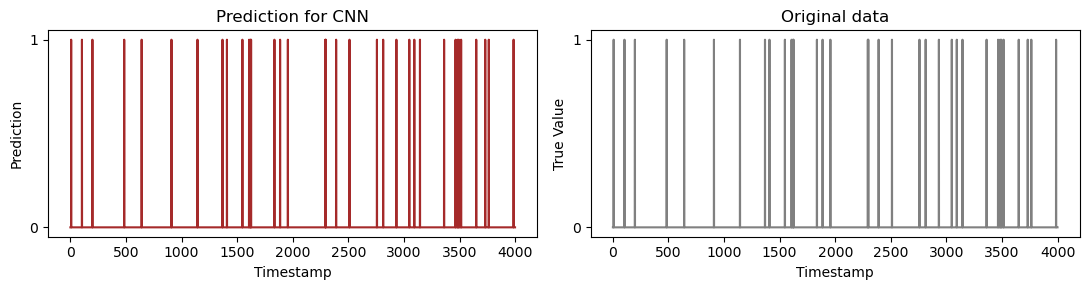

<Figure size 1100x300 with 0 Axes>

In [47]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for CNN")
plt.plot(np.arange(len(y_pred_cnn[19000:23000].cpu())),y_pred_cnn[19000:23000].cpu(),color="brown")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('CNN.png')

# Evaluation Metric for CNN

86.0


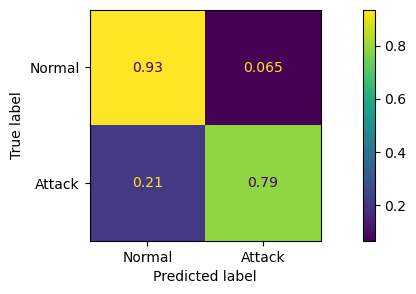

In [44]:
model_cm =confusion_matrix(y_test, y_pred_cnn.cpu().detach().numpy(),normalize='true')
# print(round(accuracy_score(y_test, y_pred_cnn.cpu()),2)*100)
y_acc = accuracy_score(y_test, y_pred_cnn.cpu())
y_f1score = f1_score(y_test, y_pred_cnn.cpu())
y_recall = recall_score(y_test, y_pred_cnn.cpu())
print(round(balanced_accuracy_score(y_test, y_pred_cnn.cpu()),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
# plt.savefig(f'{type(model).__name__}.png')

In [38]:
print(classification_report(y_test, y_pred_cnn.cpu()))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94   1560065
           1       0.74      0.79      0.76    363663

    accuracy                           0.91   1923728
   macro avg       0.84      0.86      0.85   1923728
weighted avg       0.91      0.91      0.91   1923728



# CANintelliDS

In [39]:
model3 = CANintelliIDS.load_from_checkpoint('CNN_GRU.ckpt')

In [40]:
model3.to('cuda')
model3.eval()
predictions = []
with torch.no_grad():
    for x, _ in test_dataloader:
        y_hat = model3(x.to('cuda'))
        y_hat_binary = (y_hat >= 0.5).int()
        predictions.append(y_hat_binary)
predictions = torch.cat(predictions, dim=0)

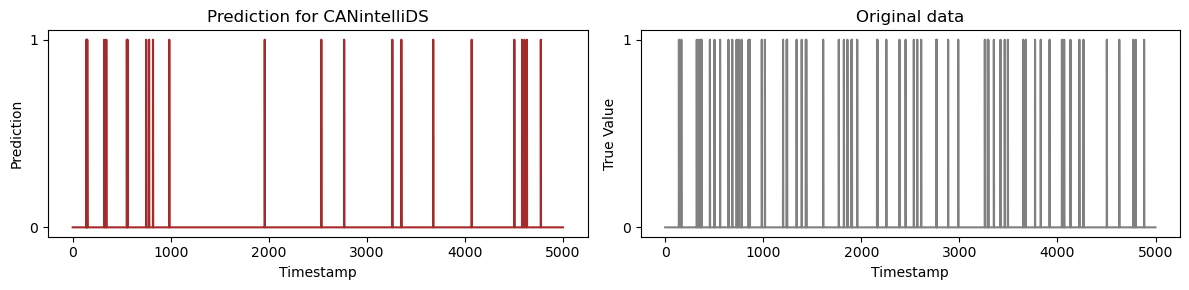

<Figure size 1100x300 with 0 Axes>

In [53]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for CANintelliDS")
plt.plot(np.arange(len(predictions[23000:28000].cpu())),predictions[23000:28000].cpu(),color="brown")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[23000:28000])),y_test[23000:28000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('CANintelliDS.png')

# Evaluation metric for CANintelliDS

85.0


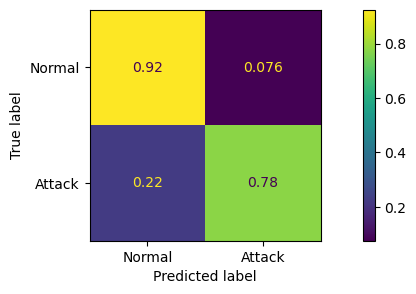

In [46]:
model_cm =confusion_matrix(y_test, predictions.cpu().detach().numpy(),normalize='true')
# print(round(accuracy_score(y_test, predictions.cpu()),2)*100)
y_acc = accuracy_score(y_test, predictions.cpu())
y_f1score = f1_score(y_test, predictions.cpu())
y_recall = recall_score(y_test, predictions.cpu())
print(round(balanced_accuracy_score(y_test, predictions.cpu()),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
# plt.savefig(f'{type(model).__name__}.png')

In [43]:
print(classification_report(y_test, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94   1560065
           1       0.70      0.78      0.74    363663

    accuracy                           0.90   1923728
   macro avg       0.83      0.85      0.84   1923728
weighted avg       0.90      0.90      0.90   1923728



# Deep Hybrid Learning Approach with CNN for feature extraction

In [11]:
model_cnn = CNN.load_from_checkpoint("oned_cnn.ckpt")

In [12]:
cnn_feature_extractor = model_cnn
cnn_feature_extractor.fc = nn.Identity()
cnn_feature_extractor.to('cuda')

CNN(
  (conv1d_layer_1): Sequential(
    (0): Conv1d(1, 12, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv1d_layer_2): Sequential(
    (0): Conv1d(12, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (linear3): Linear(in_features=144, out_features=32, bias=True)
  (fc): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (metric): CrossEntropyLoss()
)

In [13]:
from torch.utils.data import Subset, DataLoader

# define the downsampling factor
downsampling_factor = 8

# create a subset of the dataset with the specified downsampling factor
subset_indices = list(range(0, len(TrainDataset()), downsampling_factor))
train_subset = Subset(TrainDataset(), subset_indices)

# create a dataloader for the subset
train_dataloader_subset = DataLoader(train_subset, batch_size=1024, shuffle=True)

# collect the features and labels for the subset
target_list = []
feature_list = []
for batch in train_dataloader_subset:
    with torch.no_grad():
        x, y = batch
        Xtrain_feature = cnn_feature_extractor(x.to('cuda'))
        target_list.append(y)
        feature_list.append(Xtrain_feature.to('cuda'))
        del Xtrain_feature

Xtrain_feature = torch.cat(feature_list)
y_train = torch.cat(target_list)


In [48]:
estimators= [
    ('catboost',CatBoostClassifier(task_type='GPU',iterations=2,silent=True)),
    ('DT', DecisionTreeClassifier()),
    ('XGB',XGBClassifier()),
    ('LGBM', LGBMClassifier(verbose_eval=-1)),
    ('AdaBoost',AdaBoostClassifier()),
    ('GaussianNB',GaussianNB()),
    ('GBC',GradientBoostingClassifier())

]

In [49]:
final_estimator=LogisticRegression()

In [50]:
clf = StackingClassifier(estimators, final_estimator)

# Passing the extracted features from CNN as input to the Stacking Classifier

In [51]:
clf.fit(Xtrain_feature.cpu().detach().numpy(),y_train.cpu().detach().numpy())

[LightGBM] [Warning] Unknown parameter: verbose_eval


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval


StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001956FF1AB50>),
                               ('DT', DecisionTreeClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_type...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('LGBM', LGBMClassifier(verbose_eval=-1)),
                               ('AdaBoost', AdaBoostClassifier()),
                               ('GaussianNB', GaussianNB()),
                               ('GBC', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression())

In [52]:
final_estimator = clf.final_estimator_ 

In [53]:
weights = final_estimator.coef_[0]

In [54]:
weights

array([ 0.31995134,  2.1666108 ,  4.12006964,  1.67918863, 47.02945592,
        0.1224032 , -2.76594779])

# Weights of Base Models for DHL CNN Stacked Ensemble

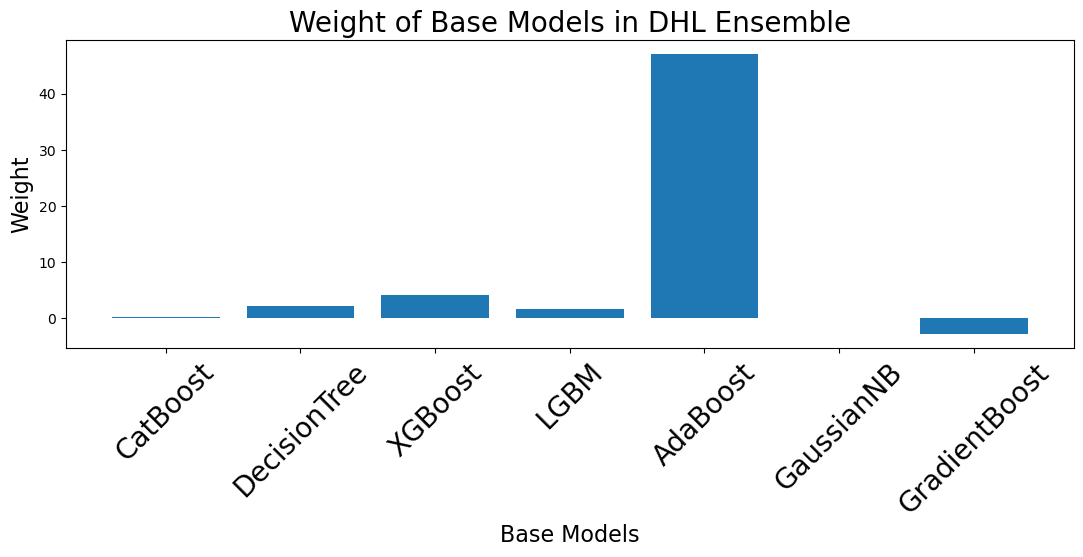

In [71]:
import matplotlib.pyplot as plt

# create a list of model names
model_names = ['CatBoost', 'DecisionTree', 'XGBoost', 'LGBM', 'AdaBoost','GaussianNB','GradientBoost']

# create the array
weights = [0.31995134,  2.1666108 ,  4.12006964,  1.67918863, 47.02945592, 0.1224032 , -2.76594779]
fig = plt.figure()
plt.rcParams["figure.figsize"] = (13,4)
# create a bar plot
plt.bar(range(len(weights)),weights)
plt.xlabel(('Base Models'),fontsize=16)
plt.ylabel(('Weight'),fontsize=16)
plt.xticks(range(len(model_names)), model_names, fontsize=20,rotation=45)

plt.title(('Weight of Base Models in DHL Ensemble'),fontsize=20)
plt.show()



In [56]:
estimators= [

    ('AdaBoost',AdaBoostClassifier())

]

In [57]:
final_estimator=LogisticRegression()

In [58]:
stk_clf = StackingClassifier(estimators, final_estimator)

In [59]:
stk_clf.fit(Xtrain_feature.cpu().detach().numpy(),y_train.cpu().detach().numpy())

StackingClassifier(estimators=[('AdaBoost', AdaBoostClassifier())],
                   final_estimator=LogisticRegression())

In [63]:
final_estimator = stk_clf.final_estimator_ 

In [64]:
weights = final_estimator.coef_[0]

In [65]:
weights

array([136.9899974])

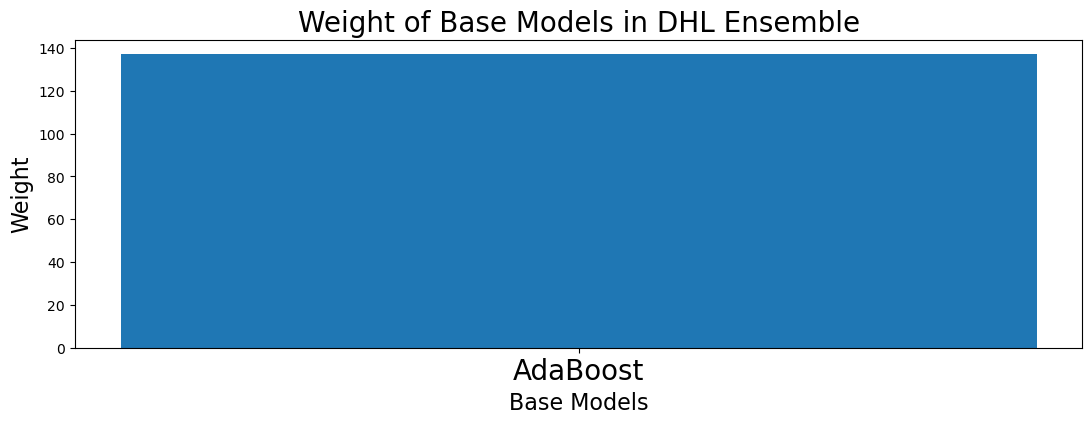

In [70]:
import matplotlib.pyplot as plt

# create a list of model names
model_names = ['AdaBoost']

# create the array
weights = [136.9899974]
fig = plt.figure()
plt.rcParams["figure.figsize"] = (13,4)

# create a bar plot
plt.bar(range(len(weights)),weights)
plt.xlabel(('Base Models'),fontsize=16)
plt.ylabel(('Weight'),fontsize=16)
plt.xticks(range(len(model_names)), model_names, fontsize=20)

plt.title(('Weight of Base Models in DHL Ensemble'),fontsize=20)
plt.show()




In [72]:
feature_list = []
for batch in test_dataloader:
    with torch.no_grad():
    

        x_test,_ = batch
        Xtest_feature = cnn_feature_extractor(x_test.to('cuda'))
        feature_list.append(Xtest_feature)

Xtest_feature = torch.cat(feature_list)

    

In [73]:
stk_pred = stk_clf.predict(Xtest_feature.cpu().detach().numpy())

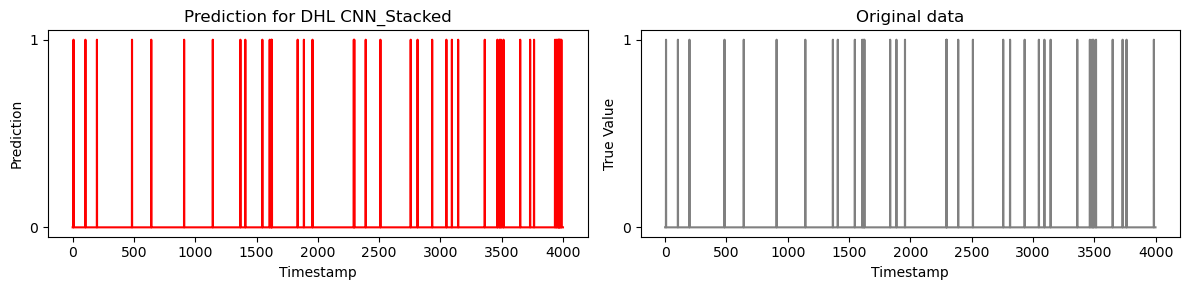

<Figure size 1100x300 with 0 Axes>

In [77]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for DHL CNN_Stacked")
plt.plot(np.arange(len(stk_pred[19000:23000])),stk_pred[19000:23000],color="red")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Prediction for DHL CNN_Stacked.png')

90.0
              precision    recall  f1-score   support

           0       0.95      0.92      0.94   1560065
           1       0.70      0.80      0.75    363663

    accuracy                           0.90   1923728
   macro avg       0.83      0.86      0.84   1923728
weighted avg       0.90      0.90      0.90   1923728



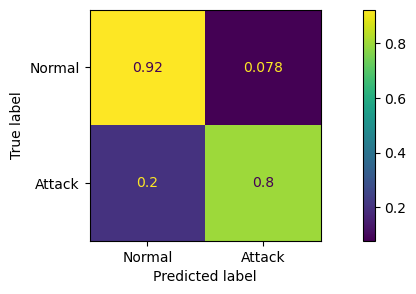

In [78]:
model_cm =confusion_matrix(y_test, stk_pred,normalize='true')
print(round(accuracy_score(y_test, stk_pred),2)*100)
y_acc = accuracy_score(y_test, stk_pred)
y_f1score = f1_score(y_test, stk_pred)
y_recall = recall_score(y_test, stk_pred)
y_bal = balanced_accuracy_score(y_test, stk_pred)
print(classification_report(y_test, stk_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
